# Can you create an oracle with a different number of solutions? How does the accuracy of the quantum counting algorithm change?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.problems import grover_problem_oracle

In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

**Creating a oracle and diffuser on 3 qubits with 2 solutions |011> and |101>**

In [3]:
def grover_unsolved():
    n=3
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)
    #oracle
    qc.cz(0, 2)
    qc.cz(1, 2)
    #diffuser         #use the model of general diffuser
    qc.h(range(3))
    qc.x(range(3))
    qc.h(2)
    qc.mct([0,1],2)
    qc.h(2)
    qc.x(range(3))
    qc.h(range(3))

    return qc

In [4]:
grit = grover_unsolved().to_gate()
grit.label = "Grover"
cgrit = grit.control()

In [5]:
#This code implements the QFT on n qubits:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(3)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [6]:
# inversing the circuit
qft_dagger = qft(3).to_gate().inverse()
qft_dagger.label = "QFT†"

In [7]:
# Create QuantumCircuit
t = 3   # no. of counting qubits
n = 3   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t): # qubits in range of counting quibts
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)]) #controlled grover oracle
    iterations *= 2     # iteration in power of 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw()

┌───┐                                                                  »
q_0: ┤ H ├─────■────────────────────────────────────────────────────────────»
     ├───┤     │                                                            »
q_1: ┤ H ├─────┼──────────■──────────■──────────────────────────────────────»
     ├───┤     │          │          │                                      »
q_2: ┤ H ├─────┼──────────┼──────────┼──────────■──────────■──────────■─────»
     ├───┤┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
q_3: ┤ H ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_4: ┤ H ├┤1 Grover ├┤1 Grover ├┤1 Grover ├┤1 Grover ├┤1 Grover ├┤1 Grover ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_5: ┤ H ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├»
     └───┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                ┌───────┐┌─┐      
«q_0: ───────────┤0      ├┤M├──────
«                │       │└╥┘┌─┐   
«q_1: ───────────┤1 QFT† ├─╫─┤M├───
«                │       │ ║ └╥┘┌─┐
«q_2: ─────■─────┤2      ├─╫──╫─┤M├
«     ┌────┴────┐└───────┘ ║  ║ └╥┘
«q_3: ┤0        ├──────────╫──╫──╫─
«     │         │          ║  ║  ║ 
«q_4: ┤1 Grover ├──────────╫──╫──╫─
«     │         │          ║  ║  ║ 
«q_5: ┤2        ├──────────╫──╫──╫─
«     └─────────┘          ║  ║  ║ 
«c: 3/═════════════════════╩══╩══╩═
«                          0  1  2

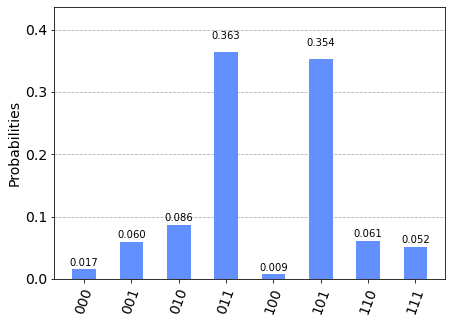

In [8]:
# Execute and see results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

In [9]:
measured_str = max(hist, key=hist.get)

In [10]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 3


In [11]:
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 2.35619


In [12]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 1.2


**The result is not so accurate but we can guess that there are more than one solutions**

In [13]:
m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 2.86
